In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import json
import copy

if not os.path.exists(os.path.join(os.getcwd(), 'config.json')):
  # preventing to go always to the parent folder everytime we run the jupyter notebook without restarting
  os.chdir("..")
if not os.getcwd() in sys.path:
  sys.path.append(os.getcwd())

from analysis.analysis_commons import *
from strategies import *

In [2]:
# Main config
main_config = None
with open('config.json') as config_file:
  main_config = json.load(config_file)

main_config["database"]["database"] = "wikidump"

runs = 5
flipped = True
delayed_response_steps = 10 

selected_topics = [] 
with open('data/contrasting_arguments_labeled_stats_selected.csv', 'r') as f:
  reader = csv.DictReader(f)
  for r in reader:
    if int(r['Selected']) != 1:
      continue
    selected_topics.append(r['Mitigator'] + ' vs ' + r['Disinformer'])
print("Selected topics:", selected_topics)

f = open('data/datavoids_per_topic_filtered.json', 'r')
datavoids_per_topic = json.load(f)
check_repeated_keys(datavoids_per_topic)

to_ignore = [
  # 'Declarative Language vs Procedural Language',
  # # 'Optimism vs Pessimism',
  # # 'Rationalism vs Empiricism',
  # 'Consumerism vs Minimalism',
  # 'Classical Economics vs Keynesian Economics',
  # 'Individualism vs Collectivism',
  # 'Direct Democracy vs Representative Democracy',
  # 'Bayesian Statistics vs Frequentist Statistics'
]

strategies_to_run = [
  RandomStrategy, 
  GreedyStrategy,
  MultiObjectiveStrategy
]

outputs = {}

def run_simulation_for_delay(config, keyword, steps_delay, delayed_response_step, dis_strategy, mit_strategy, mit_group, dis_opponent_group):
  
  def stop_if_greater(agent): 
    _, wavgrank_val = top_k_group_analysis(agent.graph, config)
    return wavgrank_val[mit_group] > wavgrank_val[dis_opponent_group]

  def stop_after_delay_dis(agent):
    return agent.steps_count > steps_delay

  if dis_strategy == RandomStrategy:
    dis_strategy_inst = RandomStrategy(42)
  else:
    dis_strategy_inst = dis_strategy()
  disinformer_strategy = ConditionalEndStrategy(
    dis_strategy_inst, 
    stop_after_delay_dis
  )
  if mit_strategy == OptimalCostsStrategy:
    mit_strategy_inst = OptimalCostsStrategy()
  elif mit_strategy == OptimalCostsStrategyLimited:
    mit_strategy_inst = OptimalCostsStrategyLimited(max_steps=steps_delay)
  else:
    mit_strategy_inst = mit_strategy()
  mitigator_strategy = DelayedStartStrategy(
    ConditionalEndStrategy(mit_strategy_inst, lambda agent: stop_if_greater(agent)), 
    steps_delay
  )

  config["output_filename"] = run_simple_simulation(
    keyword, 
    mitigator_strategy, 
    disinformer_strategy, 
    f'delay_costs-{mit_strategy_inst.get_strategy_name()}-{dis_strategy_inst.get_strategy_name()}-{steps_delay}',
    config,
    mute_output=True,
    number_of_runs=runs if mit_strategy == RandomStrategy or dis_strategy == RandomStrategy else 1,
    delete_results_if_exist=False,
    delete_pagerank=True
  )
  steps_per_strategy, strategies, _ = get_output(config)
  steps = steps_per_strategy[strategies[0]]
  num_simulations = min(len(steps[0][dis_opponent_group]['weighted_avg_rank']), len(steps[0][mit_group]['weighted_avg_rank']))
  costs = []
  nodes_added = []
  for no_sim in range(num_simulations):
    # we need to determine what is the last step for that run
    last_step = 0
    for step in range(len(steps)): 
      if steps[step][dis_opponent_group]['weighted_avg_rank'][no_sim] is not None and \
         steps[step][mit_group]['weighted_avg_rank'][no_sim] is not None:
        last_step = step

    dis_weighted_rank_at_delay = steps[last_step][dis_opponent_group]['weighted_avg_rank'][no_sim]
    mit_weighted_rank_at_delay = steps[last_step][mit_group]['weighted_avg_rank'][no_sim]
    if mit_weighted_rank_at_delay >= dis_weighted_rank_at_delay:
      costs.append(steps[last_step][mit_group]['cost'][no_sim])
      nodes_added.append(steps[last_step][mit_group]['nodes_added'][no_sim])
    else:
      costs.append(-1)
      nodes_added.append(-1)

  return costs, nodes_added

def run_for_delay(config, simulation_label, keyword, steps_delay, delayed_response_step, dis_strategy, mit_strategy):
  mit_group = config['mitigator_keyword']
  dis_opponent_group = config['disinformer_keyword']
  config["output_filename"] = 'results/' + create_simulation_name(config, simulation_label)

  #if exists no need to run simulations
  # if not os.path.exists(config["output_filename"]):
  costs, nodes_added = run_simulation_for_delay(config, keyword, steps_delay, delayed_response_step, 
                                   dis_strategy, mit_strategy, mit_group, dis_opponent_group)
  # else:
  #   steps_per_strategy, strategies, id_max_rank = get_output(config)
  #   steps = steps_per_strategy[strategies[0]]
  #   num_simulations = len(steps[0][dis_opponent_group]['weighted_avg_rank'])
  #   costs = []
  #   for no_sim in range(num_simulations):
  #     dis_weighted_rank_at_delay = steps[min(steps_delay, len(steps) - 1)][dis_opponent_group]['weighted_avg_rank'][no_sim]
  #     mit_cost_to_overcome = None
  #     for i in range(min(steps_delay, len(steps) - 1)):
  #       mit_weighted_rank_at_delay = steps[i][mit_group]['weighted_avg_rank'][no_sim]
  #       if mit_weighted_rank_at_delay >= dis_weighted_rank_at_delay:
  #         mit_cost_to_overcome = steps[i][mit_group]['cost'][no_sim]
  #         break
  #     if mit_cost_to_overcome:
  #       costs.append(mit_cost_to_overcome)
  #     else:
  #       costs.append(-1)
  
  outputs[config['topic_name']][dis_strategy.__name__][mit_strategy.__name__][steps_delay] = (costs, nodes_added)

def run_for_config(config, keyword):
  config["database"]["database"] = "wikidump"
  groups_count = label_database(config)
  max_steps = min([c for _, c in groups_count.items()])
  step_increment = max(1, max_steps // delayed_response_steps)

  for dis_strategy in strategies_to_run:
    for mit_strategy in strategies_to_run + [OptimalCostsStrategy]:
      steps_delay = step_increment 
      delayed_response_step = 0

      if dis_strategy.__name__ not in outputs[config['topic_name']]:
        outputs[config['topic_name']][dis_strategy.__name__] = {}
      
      if mit_strategy.__name__ not in outputs[config['topic_name']][dis_strategy.__name__]:
        outputs[config['topic_name']][dis_strategy.__name__][mit_strategy.__name__] = {}

      # simulation_label = f'eval-all-{(mit_strategy()).get_strategy_name()}-{(dis_strategy()).get_strategy_name()}'
      # config["output_filename"] = 'results/' + create_simulation_name(config, simulation_label)
      # if not os.path.exists(config["output_filename"]):
      config["database"]["database"] = "wikilite"
      groups_count = prepare_db(config, force_preparation=True)
      simulation_label = None
      # else:
        # config["database"]["database"] = "wikidump"

      while steps_delay < max_steps:
        run_for_delay(config, simulation_label, keyword, steps_delay, delayed_response_step, dis_strategy, mit_strategy)
        steps_delay += step_increment
        delayed_response_step += 1

def run_for_topic(topic):
  print("Topic:", topic)

  topic_parts = topic.split(' vs ')
  mitigator_id = datavoids_per_topic[topic]['mitigator_id']
  disinformer_id = datavoids_per_topic[topic]['disinformer_id']
  mitigator_label = label_for_topic(datavoids_per_topic[topic]['mitigator'])
  disinformer_label = label_for_topic(datavoids_per_topic[topic]['disinformer'])
  datavoids = datavoids_per_topic[topic]['datavoids']
  main_config['datavoids'] = [datavoids]
  keyword = main_config["datavoids"][0]
  if isinstance(keyword, list):
    keyword = "|".join(keyword)
  
  print("Flipped: ", flipped)

  if flipped:
    config = clone_config_with_target(main_config, disinformer_label, mitigator_label, disinformer_id, mitigator_id)
    config['topic_name'] = topic_parts[0] + ' vs ' + topic_parts[1]
    print("Mitigator:", config["target_groups"][0])
    print("Disinformer:", config["target_groups"][1])
  else:
    config = clone_config_with_target(main_config, mitigator_label, disinformer_label, mitigator_id, disinformer_id)
    config['topic_name'] = topic_parts[1] + ' vs ' + topic_parts[0]
    print("Mitigator:", config["target_groups"][0])
    print("Disinformer:", config["target_groups"][1])

  if config['topic_name'] not in outputs:
    outputs[config['topic_name']] = {}
  
  run_for_config(config, keyword)


for topic in datavoids_per_topic.keys():
  if topic not in selected_topics:
    continue

  if topic in to_ignore:
    continue

  run_for_topic(topic)

Selected topics: ['Declarative Language vs Procedural Language', 'Optimism vs Pessimism', 'Rationalism vs Empiricism', 'Classical Economics vs Keynesian Economics']
Topic: Declarative Language vs Procedural Language
Flipped:  True
Mitigator: pro
Disinformer: dec
Labeling started
Labeling pro / dec
 Target nodes: 23801 210648
Groups count:
  dec: 51
  pro: 51
  pro|dec: 8
Groups count:
  dec: 39
  pro: 32
Done
Labeling started
Labeling pro / dec
 Target nodes: 23801 210648
Groups count:
  dec: 51
  pro: 51
  pro|dec: 8
Groups count:
  dec: 39
  pro: 32
Done
Creating important pages
Important pages: 71
Dumping important pages
Dumping idf table
Creating important edges
Important edges: 187
Dumping important edges
Connecting to lite DB
Dropping old tables
Importing important pages and edges
Importing idf
Deleting edges and nodes tables, emptying rank
Creating nodes
Creating edges
Counting
Nodes: 65246
Edges: 338
Done
Labeling started
Labeling pro / dec
 Target nodes: 23801 210648
Groups co

In [3]:
outputs

{'Declarative Language vs Procedural Language': {'RandomStrategy': {'RandomStrategy': {3: ([8.981011911502774,
      7.503700049290515,
      8.314628871180203,
      8.927991412531783,
      6.784868574693411],
     [7.0, 5.0, 6.0, 7.0, 5.0]),
    6: ([15.908051305362001,
      18.026041348652917,
      17.6551480641479,
      14.839615003932474,
      13.00807263516533],
     [12.0, 14.0, 13.0, 11.0, 9.0]),
    9: ([-1, -1, -1, -1, -1], [-1, -1, -1, -1, -1]),
    12: ([-1, -1, -1, -1, -1], [-1, -1, -1, -1, -1]),
    15: ([-1, -1, -1, -1, -1], [-1, -1, -1, -1, -1]),
    18: ([-1, -1, -1, -1, -1], [-1, -1, -1, -1, -1]),
    21: ([-1, -1, -1, -1, -1], [-1, -1, -1, -1, -1]),
    24: ([-1, -1, -1, -1, -1], [-1, -1, -1, -1, -1]),
    27: ([-1, -1, -1, -1, -1], [-1, -1, -1, -1, -1]),
    30: ([-1, -1, -1, -1, -1], [-1, -1, -1, -1, -1])},
   'GreedyStrategy': {3: ([8.772432480378097,
      8.772432480378097,
      8.772432480378097,
      8.772432480378097,
      8.772432480378097],
     [5.

In [4]:
from io import StringIO
import pandas as pd

def flatten_obj(obj, path=None):
  if path is None:
    path = []
  if isinstance(obj, dict):
    for k, v in obj.items():
      yield from flatten_obj(v, path + [k])
  else:
      yield path, obj

with open('results/delays-experiments-results.csv', 'w') as f:
  csv_writer = csv.writer(f)
  flattened_data = list(flatten_obj(outputs))
  csv_writer.writerow(['Topic', 'Disinformer', 'Mitigator', 'Delay', 'Costs', 'Nodes Added'])
  for path, values in flattened_data:
    costs, nodes_added = values
    row = path + ['|'.join(map(str, costs))] + ['|'.join(map(str, nodes_added))]
    csv_writer.writerow(row)

#read
df = pd.read_csv('results/delays-experiments-results.csv')
outputs = {}
for i in range(len(df)):
  if df.at[i, 'Topic'] not in outputs:
    outputs[df.at[i, 'Topic']] = {}
  if df.at[i, 'Disinformer'] not in outputs[df.at[i, 'Topic']]:
    outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']] = {}
  if df.at[i, 'Mitigator'] not in outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']]:
    outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']] = {}
  if df.at[i, 'Delay'] not in outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']]:
    outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']][df.at[i, 'Delay']] = []
  outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']][df.at[i, 'Delay']] = list(map(float, df.at[i, 'Costs'].split('|')))

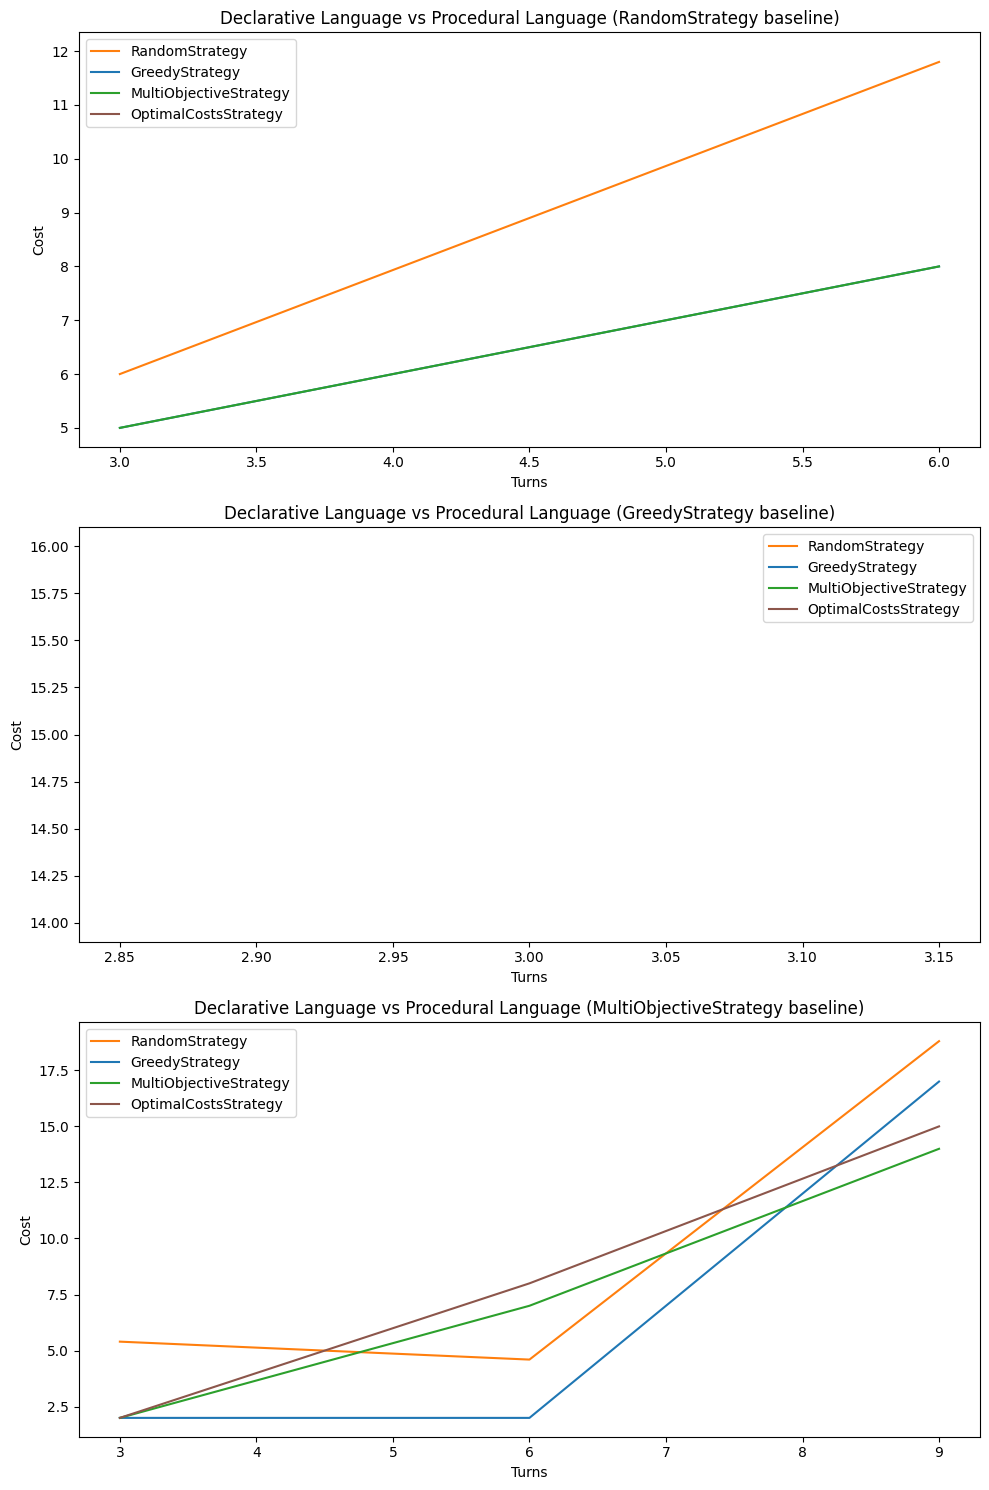

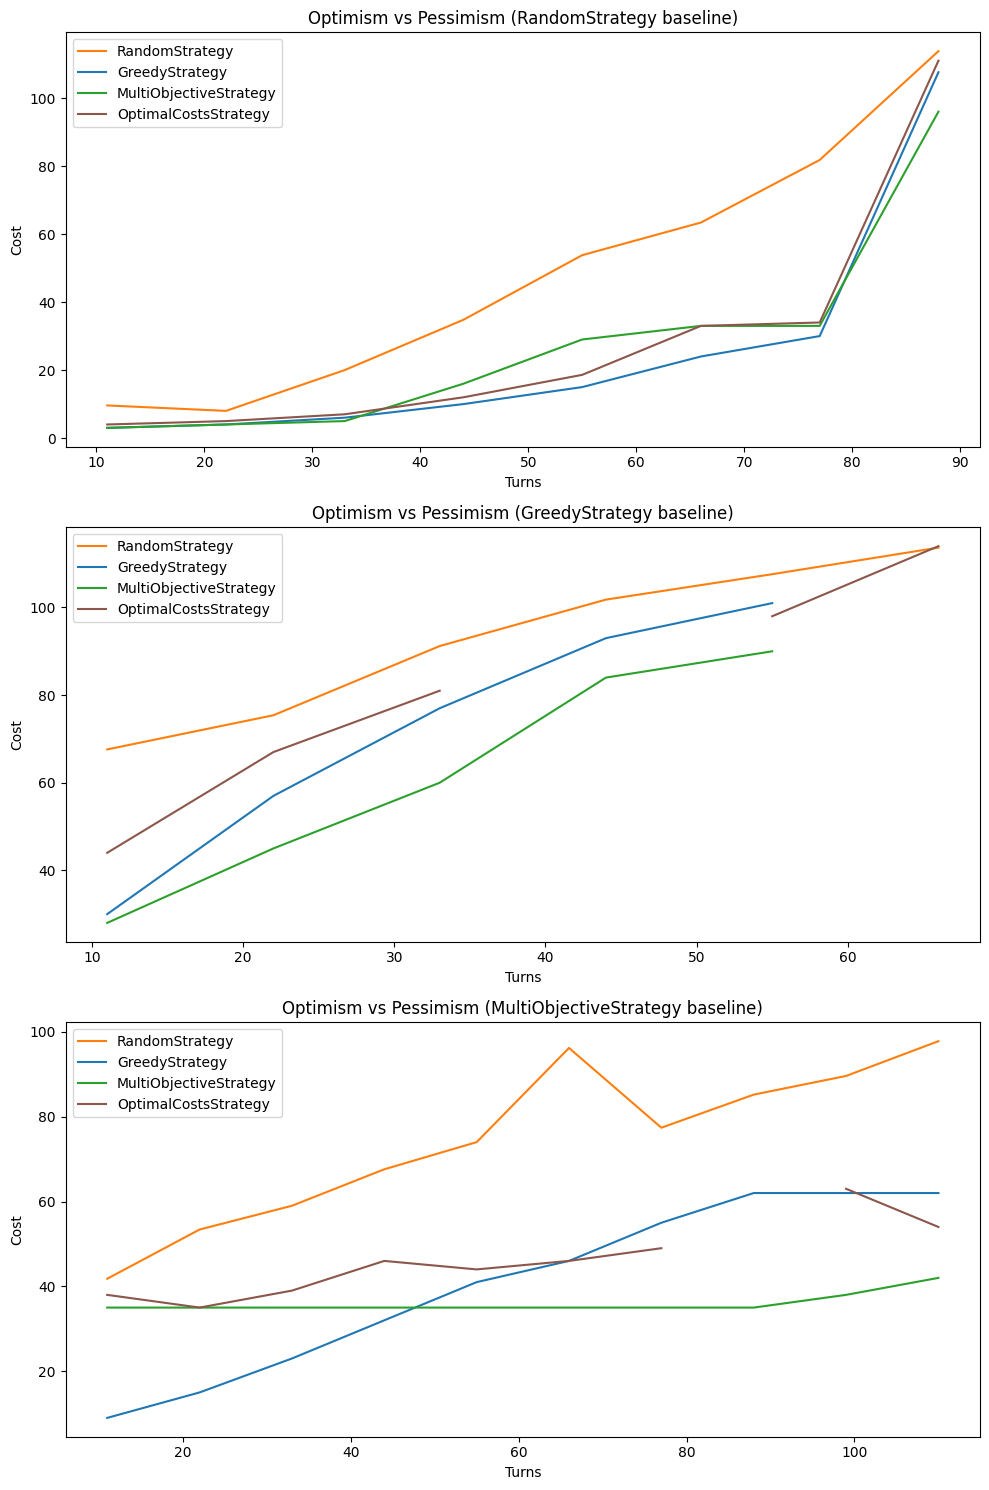

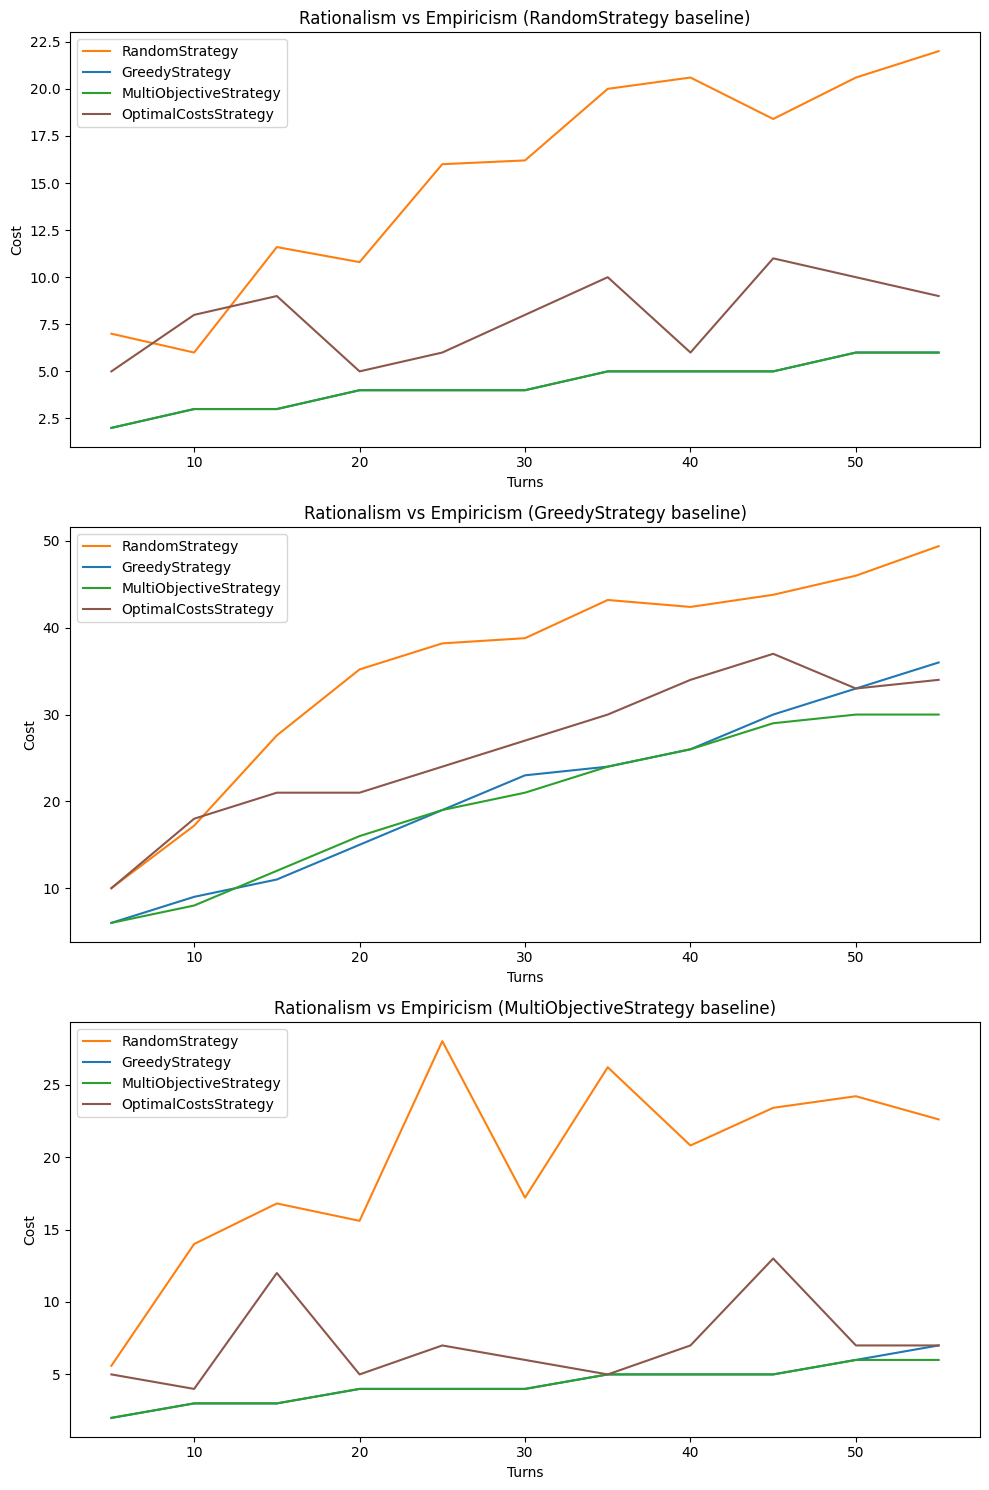

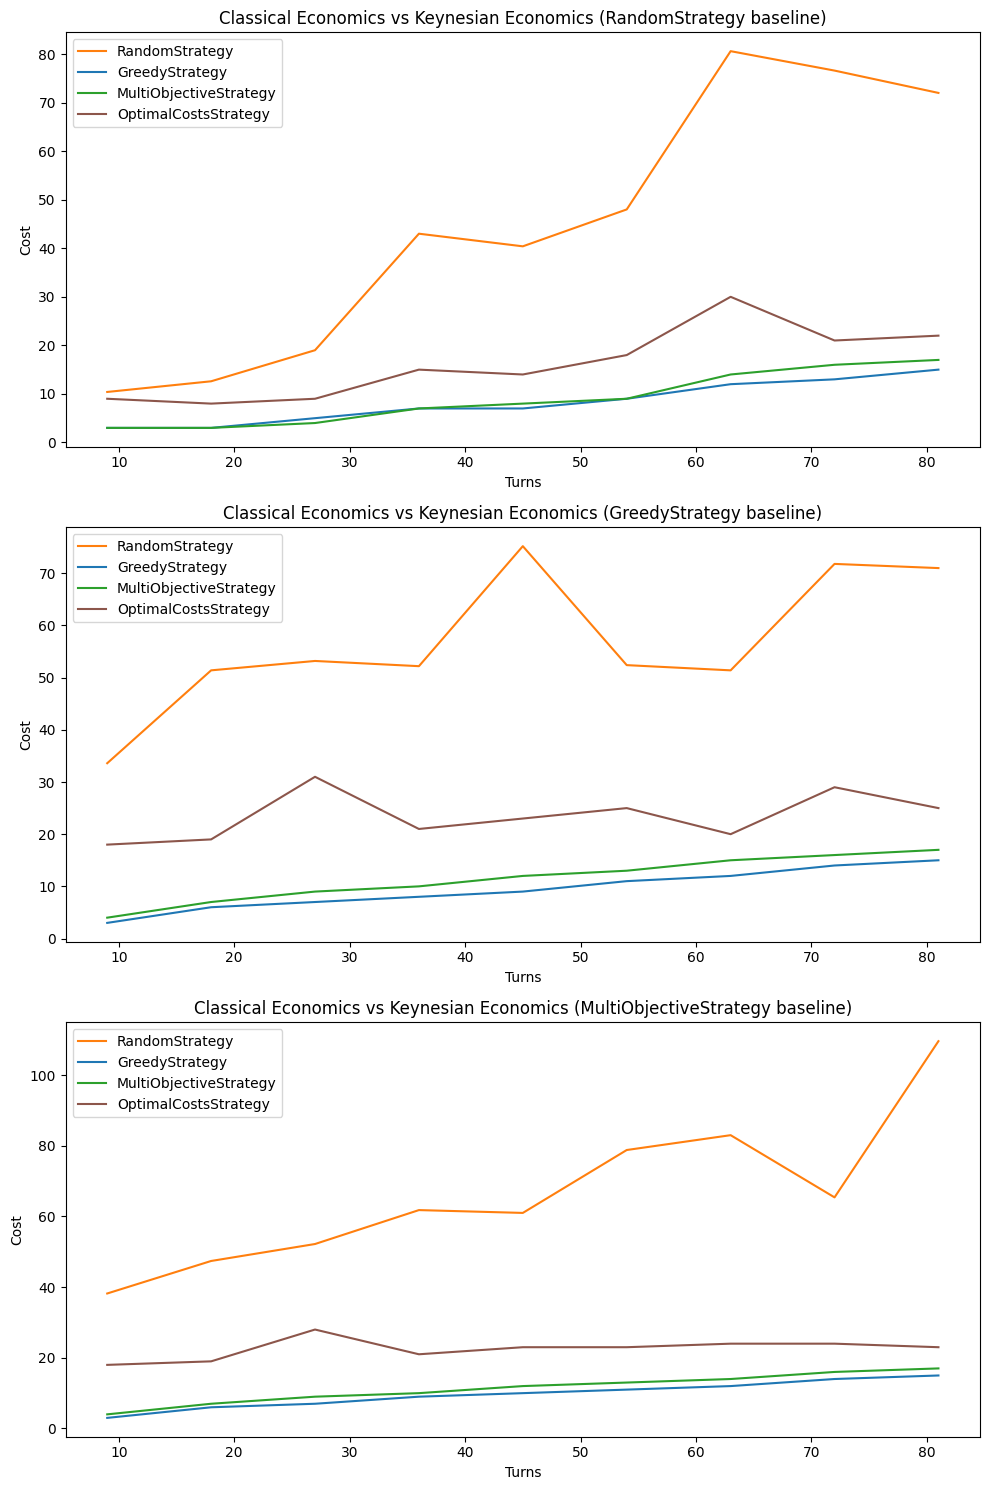

In [10]:
df = pd.read_csv('results/delays-experiments-results.csv')
outputs = {}
for i in range(len(df)):
  if df.at[i, 'Topic'] not in outputs:
    outputs[df.at[i, 'Topic']] = {}
  if df.at[i, 'Disinformer'] not in outputs[df.at[i, 'Topic']]:
    outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']] = {}
  if df.at[i, 'Mitigator'] not in outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']]:
    outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']] = {}
  if df.at[i, 'Delay'] not in outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']]:
    outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']][df.at[i, 'Delay']] = []
  outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']][df.at[i, 'Delay']] = list(map(float, df.at[i, 'Costs'].split('|')))

colors = {
    'RandomStrategy': 'tab:orange',
    'GreedyStrategy': 'tab:blue',
    'MultiObjectiveStrategy': 'tab:green',
    'OptimalCostsStrategy': 'tab:brown',
    'OptimalCostsStrategyLimited': 'tab:brown'
}

def plot(topic, outputs):
  data = outputs[topic]
  num_rows = len(data)

  fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, 5 * num_rows))

  if not isinstance(axes, np.ndarray):
      axes = [axes]

  # Plotting each strategy in its respective subplot
  for ax, (strategy, values) in zip(axes, data.items()):
      added_labels = set()  # Keep track of labels already added to the legend

      for sub_strategy, points in values.items():
          x = sorted([k for k in points.keys()])
          y = []
          for k in x:
            costs = list(filter(lambda v: v > 0, points[k])) # we exclude -1 values
            if costs:
              y.append(sum(costs) / len(costs))
            else:
              y.append(None)

          # Handling None values for transparency
          x_values, y_values = [], []
          for i in range(len(x)):
              if y[i] is not None:
                  x_values.append(x[i])
                  y_values.append(y[i])
                  if i == len(x) - 1 or y[i+1] is None:
                      if sub_strategy not in added_labels:
                          ax.plot(x_values, y_values, label=sub_strategy, color=colors[sub_strategy])
                          added_labels.add(sub_strategy)
                      else:
                          ax.plot(x_values, y_values, color=colors[sub_strategy])
                      x_values, y_values = [], []
              else:
                  if x_values:
                      if sub_strategy not in added_labels:
                          ax.plot(x_values, y_values, label=sub_strategy, color=colors[sub_strategy])
                          added_labels.add(sub_strategy)
                      else:
                          ax.plot(x_values, y_values, color=colors[sub_strategy])
                      x_values, y_values = [], []

      ax.set_title(topic + ' (' + strategy + ' baseline)')
      ax.set_xlabel('Turns')
      ax.set_ylabel('Cost')
      ax.legend()

  plt.tight_layout()
  plt.show()

for topic in outputs.keys():
  plot(topic, outputs)

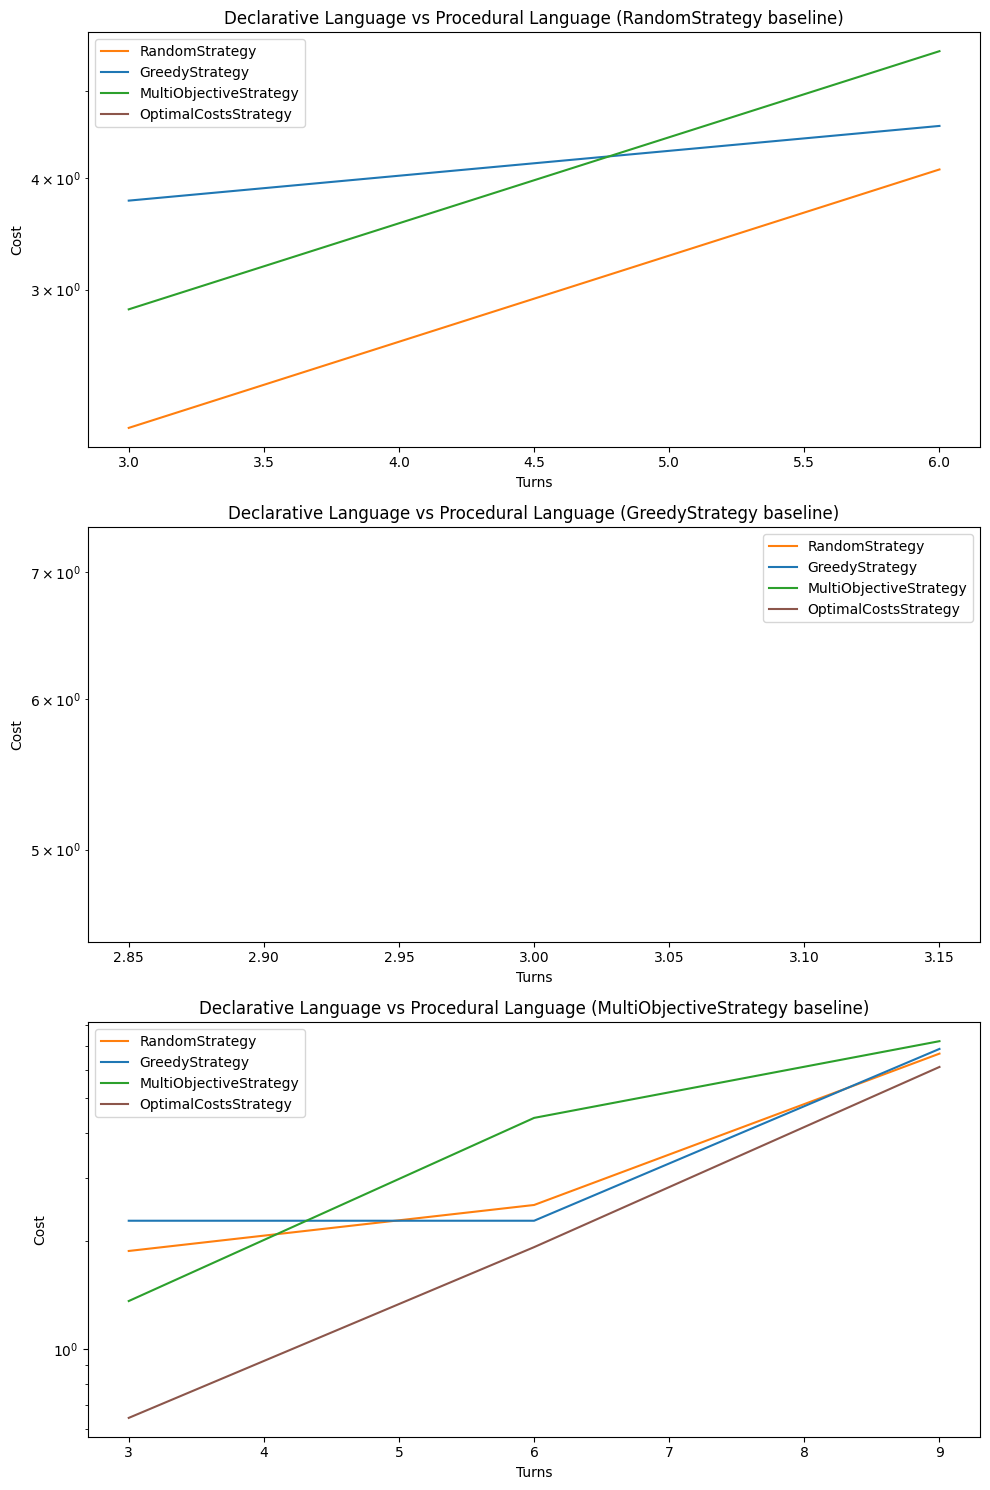

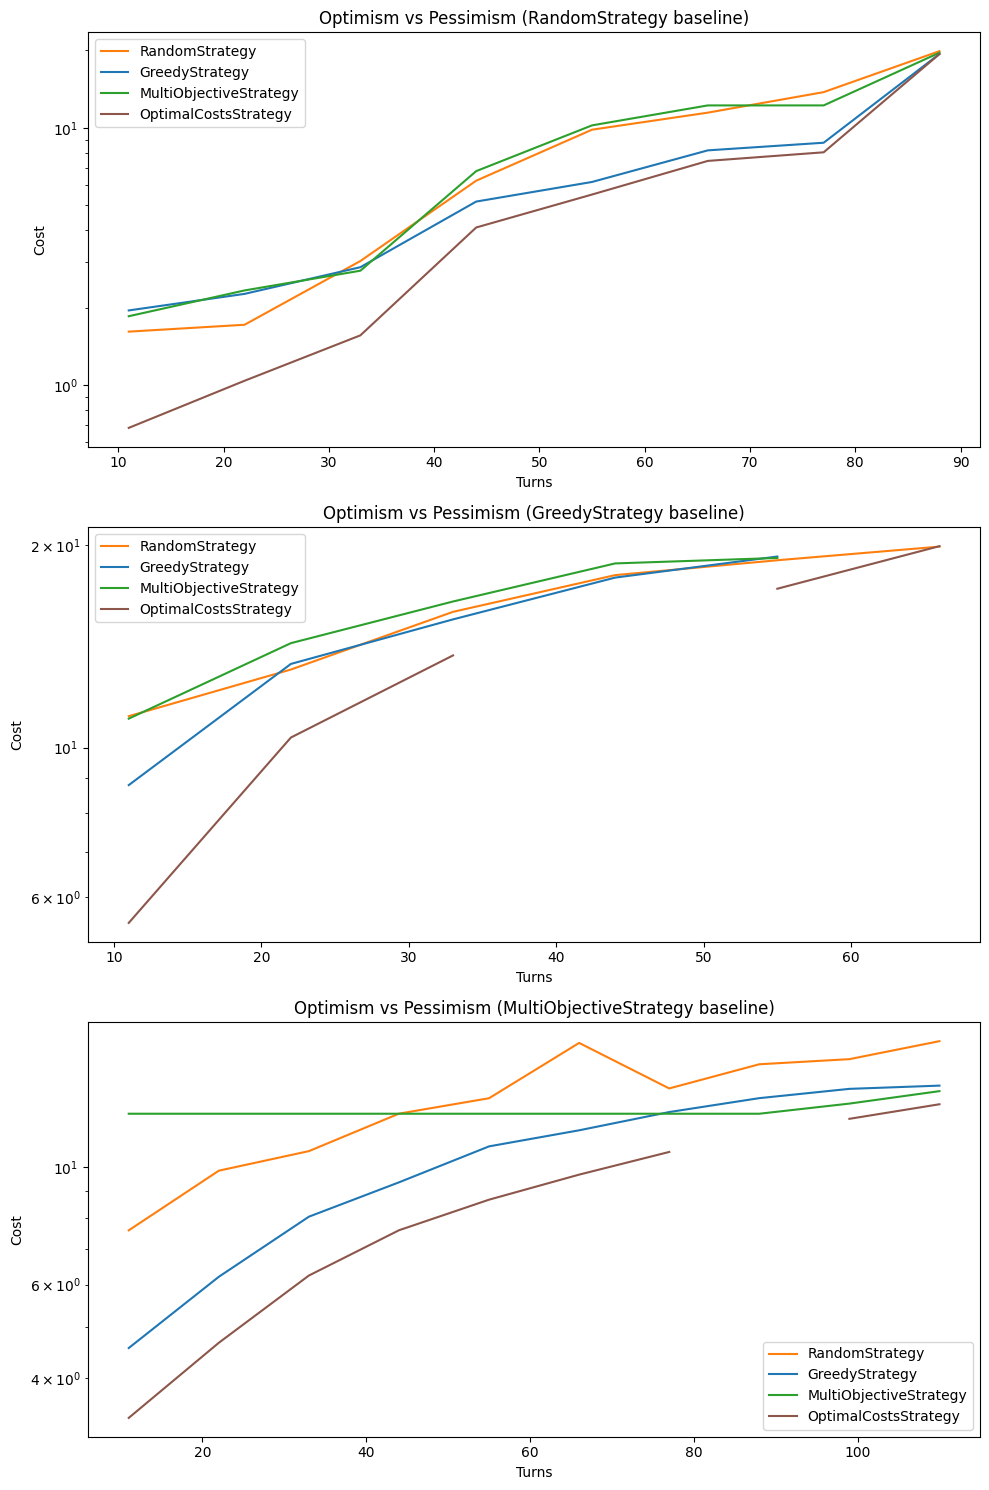

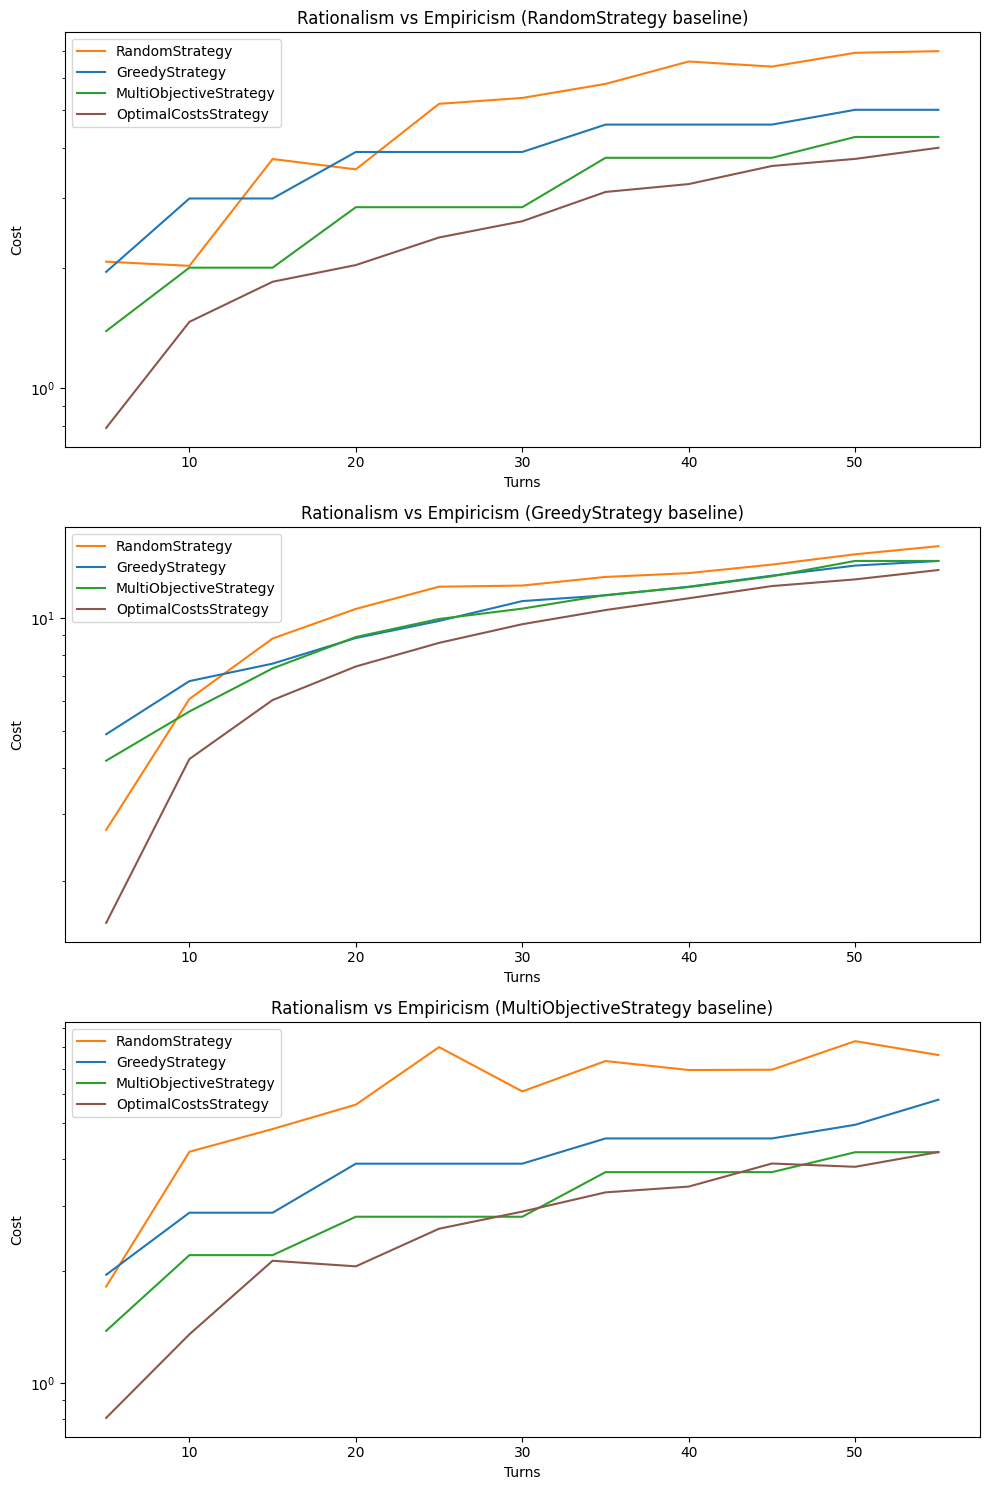

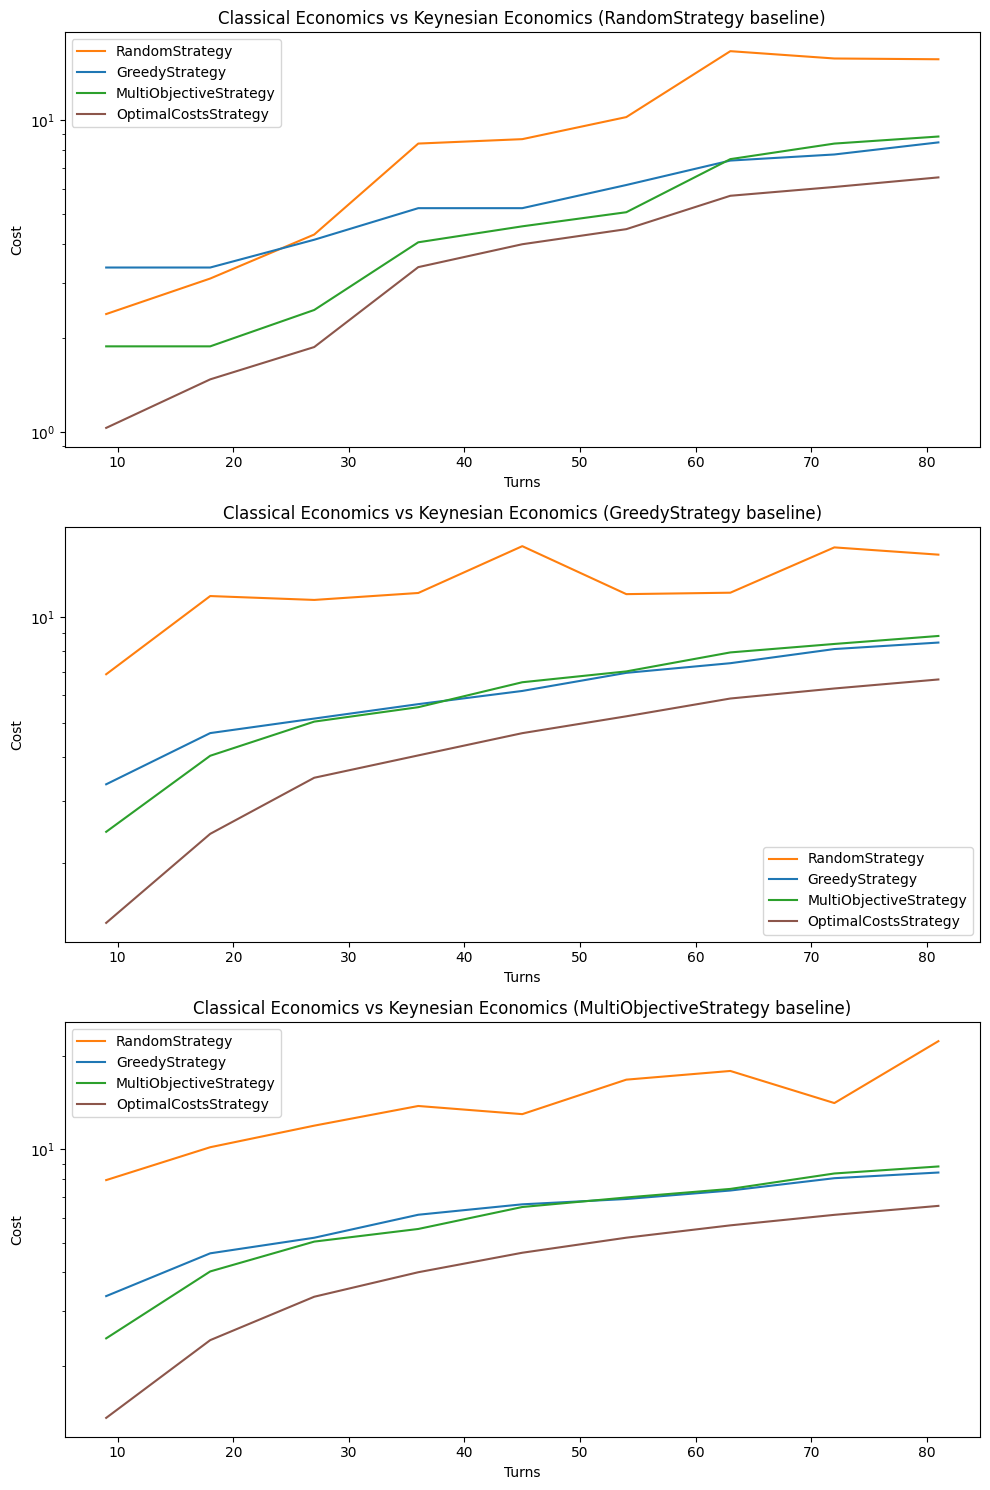

In [15]:
df = pd.read_csv('results/delays-experiments-results.csv')
outputs = {}
for i in range(len(df)):
  if df.at[i, 'Topic'] not in outputs:
    outputs[df.at[i, 'Topic']] = {}
  if df.at[i, 'Disinformer'] not in outputs[df.at[i, 'Topic']]:
    outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']] = {}
  if df.at[i, 'Mitigator'] not in outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']]:
    outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']] = {}
  if df.at[i, 'Delay'] not in outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']]:
    outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']][df.at[i, 'Delay']] = []
  outputs[df.at[i, 'Topic']][df.at[i, 'Disinformer']][df.at[i, 'Mitigator']][df.at[i, 'Delay']] = (
    list(map(float, df.at[i, 'Costs'].split('|'))),
    list(map(float, df.at[i, 'Nodes Added'].split('|')))
  )

colors = {
    'RandomStrategy': 'tab:orange',
    'GreedyStrategy': 'tab:blue',
    'MultiObjectiveStrategy': 'tab:green',
    'OptimalCostsStrategy': 'tab:brown',
    'OptimalCostsStrategyLimited': 'tab:brown'
}

def plot(topic, outputs):
  data = outputs[topic]
  num_rows = len(data)

  fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, 5 * num_rows))

  if not isinstance(axes, np.ndarray):
      axes = [axes]

  # Plotting each strategy in its respective subplot
  for ax, (strategy, values) in zip(axes, data.items()):
      added_labels = set()  # Keep track of labels already added to the legend

      for sub_strategy, points in values.items():
          x = sorted([k for k in points.keys()])
          y = []
          for k in x:
            costs = list(filter(lambda v: v > 0, points[k][0]))
            nodes_added = list(filter(lambda v: v > 0, points[k][1]))
            if costs:
              avg_costs = sum(costs) / len(costs)
              nodes_added = sum(nodes_added) / len(nodes_added)
              price_node_diff = avg_costs - nodes_added
              y.append(price_node_diff)
            else:
              y.append(None)

          # Handling None values for transparency
          x_values, y_values = [], []
          for i in range(len(x)):
              if y[i] is not None:
                  x_values.append(x[i])
                  y_values.append(y[i])
                  if i == len(x) - 1 or y[i+1] is None:
                      if sub_strategy not in added_labels:
                          ax.plot(x_values, y_values, label=sub_strategy, color=colors[sub_strategy])
                          added_labels.add(sub_strategy)
                      else:
                          ax.plot(x_values, y_values, color=colors[sub_strategy])
                      x_values, y_values = [], []
              else:
                  if x_values:
                      if sub_strategy not in added_labels:
                          ax.plot(x_values, y_values, label=sub_strategy, color=colors[sub_strategy])
                          added_labels.add(sub_strategy)
                      else:
                          ax.plot(x_values, y_values, color=colors[sub_strategy])
                      x_values, y_values = [], []

      ax.set_title(topic + ' (' + strategy + ' baseline)')
      ax.set_xlabel('Turns')
      ax.set_yscale('log')
      ax.set_ylabel('Cost')
      ax.legend()

  plt.tight_layout()
  plt.show()

for topic in outputs.keys():
  plot(topic, outputs)